In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, precision_recall_curve, average_precision_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [3]:
from link.src.py_scripts.process_pals import begin_processing

In [4]:
random_seed = 17

# Data preparation

In [23]:
# True positive data
# L1 3`UTR
df_True = pd.read_csv('L13UTR.csv', sep=';', index_col=0).drop_duplicates()

In [24]:
# True negative data
df_False = pd.read_csv('Shuffled_L1.csv', sep=';', index_col=0).drop_duplicates()

In [25]:
# Exam KnownGenes
df_KnownGenes = pd.read_csv('KnownGene3End.csv', index_col=0, sep=';')
# Exam Psudogenes
df_Pseudogenes = pd.read_csv('Pseudogenes3End.csv', index_col=0, sep=';')

# Data analysis & visualisation

In [26]:
if df_True.shape[0] > df_False.shape[0]:
    df_True_n = df_True.sample(df_False.shape[0], random_state=random_seed)
    df_False_n = df_False
else:
    df_True_n = df_True
    df_False_n = df_False.sample(df_True.shape[0], random_state=random_seed)
    
X = pd.concat([df_True_n, df_False_n], ignore_index=True)
Y = pd.Series(np.append(np.full(df_True_n.shape[0], 1), 
                        np.full(df_False_n.shape[0], 0)))

# Getting rid of unneeded columns
X = X[X.columns[(X.columns.map(len)<4)]]

In [27]:
df_KnownGenes = df_KnownGenes[df_KnownGenes.columns[(df_KnownGenes.columns.map(len)<4)]]
df_Pseudogenes = df_Pseudogenes[df_Pseudogenes.columns[(df_Pseudogenes.columns.map(len)<4)]]

In [28]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=2000)
folded_data = KFold(n_splits=5, random_state=random_seed, shuffle=True)

2019-04-06 22:50:47,823 - matplotlib.axes._base - DEBUG - update_title_pos
2019-04-06 22:50:47,955 - matplotlib.axes._base - DEBUG - update_title_pos
2019-04-06 22:50:47,986 - matplotlib.axes._base - DEBUG - update_title_pos
2019-04-06 22:50:48,008 - matplotlib.axes._base - DEBUG - update_title_pos


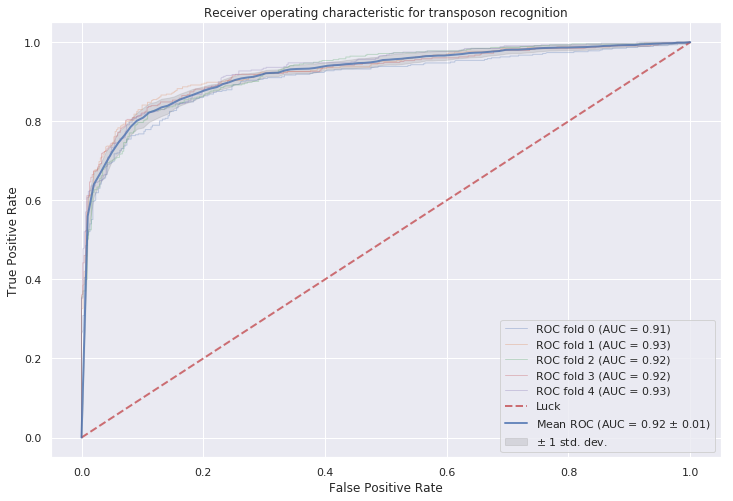

In [29]:
tprs = []
aucs, acc, rec, prec = [], [], [], []

mean_fpr = np.linspace(0, 1, 100)
i = 0

for k, (train, test) in enumerate(folded_data.split(X, Y)):
    probas_ = rf.fit(X.iloc[train], Y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y.iloc[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    Y_pred = rf.predict(X.iloc[test])
    acc.append(accuracy_score(Y.iloc[test], Y_pred))
    prec.append(precision_score(Y.iloc[test], Y_pred))
    rec.append(recall_score(Y.iloc[test], Y_pred))
    plt.plot(
        fpr,
        tpr,
        lw=1,
        alpha=0.3,
        label='ROC fold %d (AUC = %0.2f)' % (k, roc_auc)
    )

plt.plot(
    [0, 1],
    [0, 1],
    linestyle='--',
    lw=2,
    color='r',
    label='Luck',
    alpha=.8
)
fpr, tpr, thresholds = roc_curve(Y.iloc[test], probas_[:, 1])

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color='grey',
    alpha=.2,
    label=r'$\pm$ 1 std. dev.'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for transposon recognition')
plt.legend(loc="lower right")
plt.show()

2019-04-06 22:51:11,352 - matplotlib.axes._base - DEBUG - update_title_pos
2019-04-06 22:51:11,464 - matplotlib.axes._base - DEBUG - update_title_pos
2019-04-06 22:51:11,494 - matplotlib.axes._base - DEBUG - update_title_pos
2019-04-06 22:51:11,512 - matplotlib.axes._base - DEBUG - update_title_pos


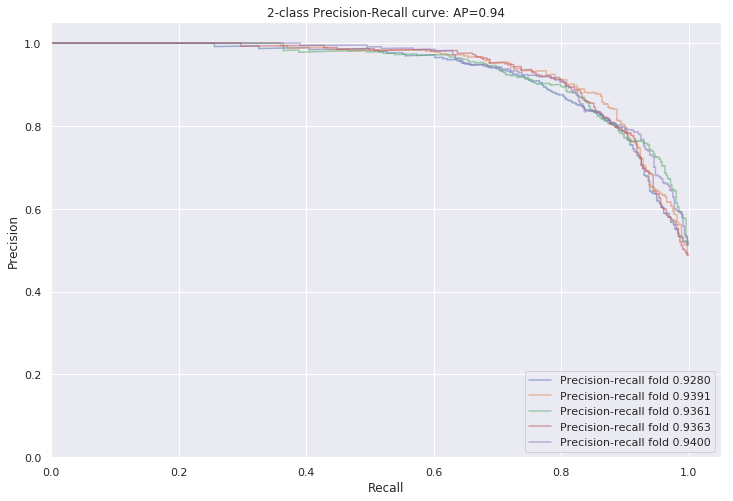

In [30]:
precisions = []

best_precision = {"precision_score": 0.0, "precision": None, "recall": None}

for k, (train, test) in enumerate(folded_data.split(X, Y)):
    probas_ = rf.fit(X.iloc[train], Y.iloc[train]).predict_proba(X.iloc[test])
    precision, recall, _ = precision_recall_curve(Y.iloc[test], probas_[:, 1])
    average_precision = average_precision_score(Y.iloc[test], probas_[:, 1])
    if average_precision > best_precision["precision_score"]:
        best_precision["precision"] = precision
        best_precision["recall"] = recall
        best_precision["precision_score"] = average_precision
    precisions.append(average_precision)
    plt.step(
        recall,
        precision,
        alpha=0.5,
        where='post',
        label='Precision-recall fold {0:0.4f}'.format(average_precision)
    )
average_precision = sum(precisions)/len(precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.legend(loc="lower right")
plt.show()

# AUC, Accuracy, Precision & Recall

In [31]:
mr = lambda x: np.round(np.mean(x), 4)
mr(aucs), mr(acc), mr(prec), mr(rec)

(0.922, 0.853, 0.8717, 0.8283)

# Feature importance

2019-04-06 22:51:12,024 - matplotlib.axes._base - DEBUG - update_title_pos
2019-04-06 22:51:12,101 - matplotlib.axes._base - DEBUG - update_title_pos
2019-04-06 22:51:12,120 - matplotlib.axes._base - DEBUG - update_title_pos
2019-04-06 22:51:12,132 - matplotlib.axes._base - DEBUG - update_title_pos


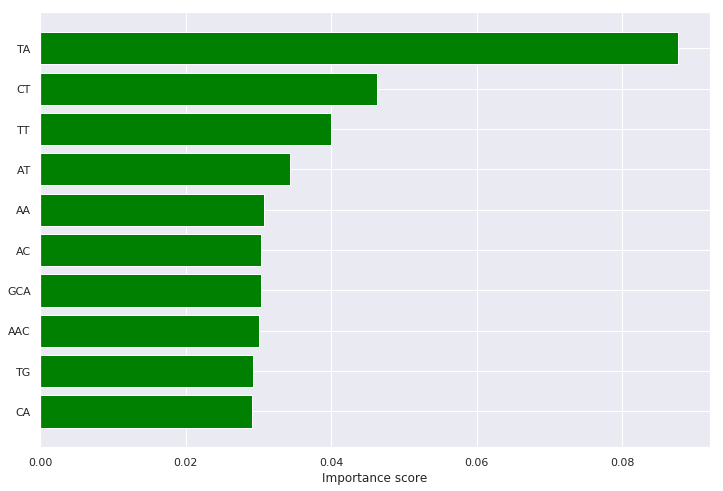

In [32]:
N_to_print = 10
y_pos = range(N_to_print)
fig, ax = plt.subplots()

feature_importance = rf.feature_importances_.round(4)
feature_importance = zip(X.keys(), feature_importance)
feature_importance = np.array(sorted(feature_importance, key=lambda x:x[1], reverse=True))

ax.barh(y_pos, feature_importance[:N_to_print, 1].astype('float'), align='center', color='green')
ax.set_yticks(np.arange(N_to_print))
ax.set_yticklabels(feature_importance[:N_to_print, 0])
ax.invert_yaxis()
ax.set_xlabel('Importance score')

plt.show()

In [33]:
feature_importance = (rf.feature_importances_).round(4)
feature_importance = zip(X.keys(), feature_importance)
feature_importance = sorted(list(feature_importance), key=lambda x:x[1], reverse=True)
fi = pd.DataFrame(feature_importance, columns=['Feature_name', 'Feature_importance'])
fi.head(N_to_print)

,Feature_name,Feature_importance
0,TA,0.0877
1,CT,0.0463
2,TT,0.0400
3,AT,0.0343
4,AA,0.0307
5,AC,0.0304
6,GCA,0.0304
7,AAC,0.0301
8,TG,0.0293
9,CA,0.0291


# Further generalization analysis block

In [34]:
CSV_FILE_SUBNAME_OBJECTS = "L1_vs_Shuffle" # "True_vs_False"
CSV_FILE_SUBNAME_TYPE = "sequence_based" # "50b.p._Stats" or "Stem-loop_Stats"
CSV_FILE_SUBNAME = "{0}__{1}".format(CSV_FILE_SUBNAME_OBJECTS, CSV_FILE_SUBNAME_TYPE)

In [35]:
pd.DataFrame({"fpr": mean_fpr, "tpr": mean_tpr}).to_csv("AUC__{0}.csv".format(CSV_FILE_SUBNAME), index=False)
pd.DataFrame({"precision": best_precision["precision"],
              "recall": best_precision["recall"]}).to_csv("Precision-Recall__{0}.csv".format(CSV_FILE_SUBNAME), index=False)
pd.DataFrame(fi).to_csv("Feature_importance__{0}.csv".format(CSV_FILE_SUBNAME), index=False)

# Pseudogen & KnownGenes test

In [36]:
# KnownGenes test
Y_pred_KnownGenes = rf.predict(df_KnownGenes)

In [37]:
knownGene_rate = np.mean(Y_pred_KnownGenes)
knownGene_rate

0.4327586542012478

In [38]:
# Pseudogenes test
Y_pred_Pseudogenes = rf.predict(df_Pseudogenes)

In [39]:
pseudogenes_rate = np.mean(Y_pred_Pseudogenes)
pseudogenes_rate

0.42027071640805547

In [41]:
with open(f'mRNA_pseudogens_recognition.txt', 'a') as file:
    file.write(f'{CSV_FILE_SUBNAME_TYPE},{knownGene_rate},{pseudogenes_rate}\n')